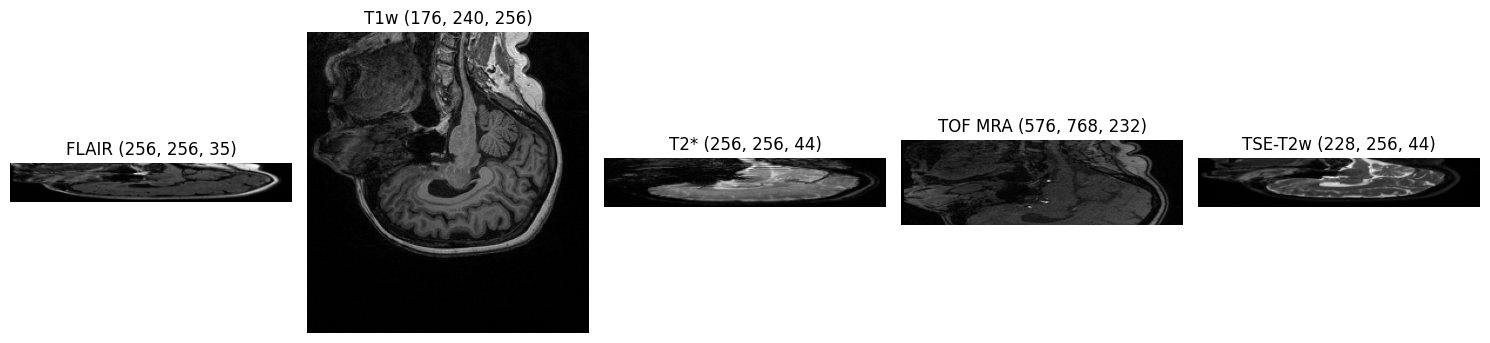

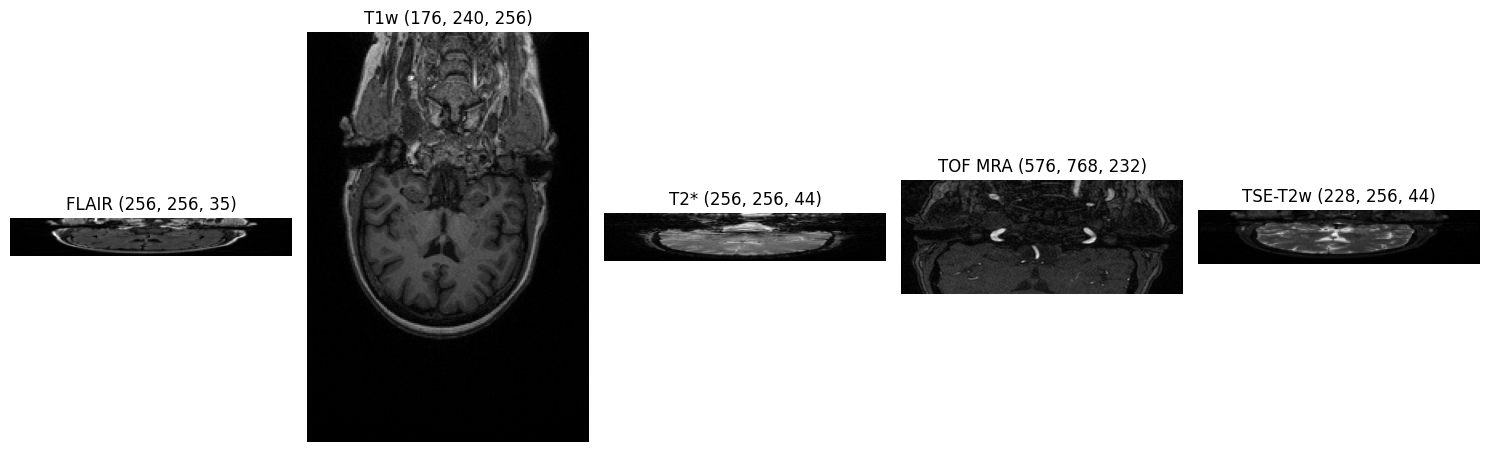

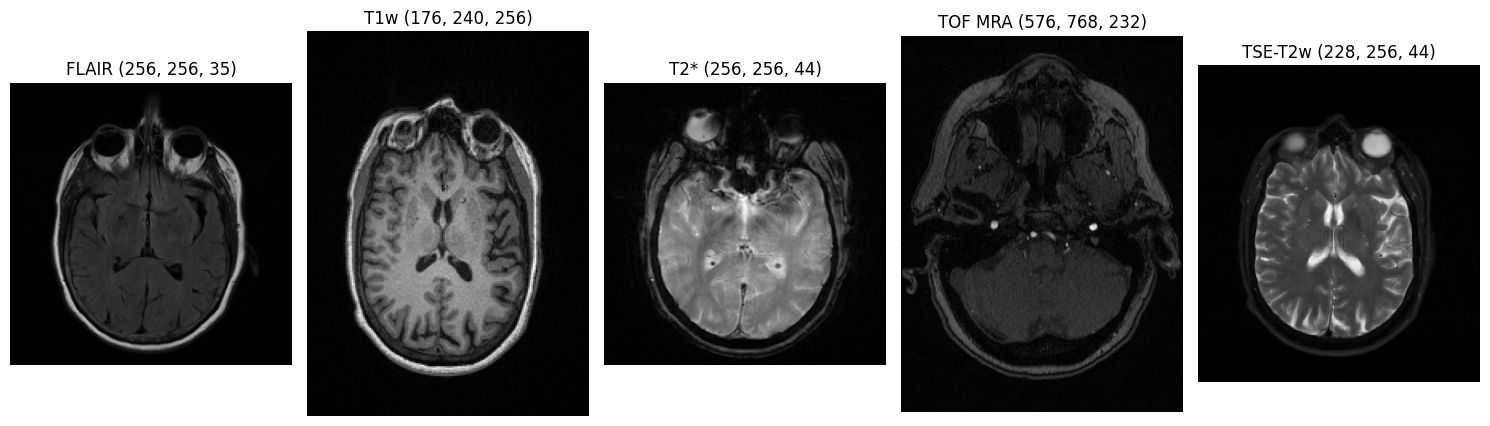

In [2]:
from oasis_util import visualize_structural_mri_session

visualize_structural_mri_session("../data/oasis-3-proc-1/OAS30001_MR_d2430/", axis=0)
visualize_structural_mri_session("../data/oasis-3-proc-1/OAS30001_MR_d2430/", axis=1)
visualize_structural_mri_session("../data/oasis-3-proc-1/OAS30001_MR_d2430/", axis=2)

In [1]:
import os
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'antialiased'
import nibabel as nib

In [4]:
from dipy.viz import regtools
from dipy.align.imaffine import (AffineMap,
                                  MutualInformationMetric,
                                  AffineRegistration)
from dipy.align.transforms import (TranslationTransform3D,
                                    RigidTransform3D,
                                    AffineTransform3D)

flair_img = nib.load("../data/oasis-3-proc-1/OAS30001_MR_d2430/sub-OAS30001_ses-d2430_FLAIR_LPS.nii.gz")
mra_img = nib.load("../data/oasis-3-proc-1/OAS30001_MR_d2430/sub-OAS30001_ses-d2430_acq-TOF_angio_LPS.nii.gz")
t2_img = nib.load("../data/oasis-3-proc-1/OAS30001_MR_d2430/sub-OAS30001_ses-d2430_acq-TSE_T2w_LPS.nii.gz")
t2_star_img = nib.load("../data/oasis-3-proc-1/OAS30001_MR_d2430/sub-OAS30001_ses-d2430_T2star_LPS.nii.gz")

t1_ref = nib.load("../data/oasis-3-proc-1/OAS30001_MR_d2430/sub-OAS30001_ses-d2430_T1w_LPS.nii.gz")


flair_data = flair_img.get_fdata()
flair_affine = flair_img.affine
mra_data = mra_img.get_fdata()
mra_affine = mra_img.affine
t2_data = t2_img.get_fdata()
t2_affine = t2_img.affine
t2_star_data = t2_star_img.get_fdata()
t2_star_affine = t2_star_img.affine

t1_ref_data = t1_ref.get_fdata()
t1_ref_affine = t1_ref.affine

identity = np.eye(4)
flair_affine_map = AffineMap(identity,
                        t1_ref_data.shape, t1_ref_affine,
                        flair_data.shape, flair_affine)
flair_resampled = flair_affine_map.transform(flair_data)

mra_affine_map = AffineMap(identity,
                        t1_ref_data.shape, t1_ref_affine,
                        mra_data.shape, mra_affine)
mra_resampled = mra_affine_map.transform(mra_data)

t2_affine_map = AffineMap(identity,
                        t1_ref_data.shape, t1_ref_affine,
                        t2_data.shape, t2_affine)
t2_resampled = t2_affine_map.transform(t2_data)

t2_star_affine_map = AffineMap(identity,
                        t1_ref_data.shape, t1_ref_affine,
                        t2_star_data.shape, t2_star_affine)
t2_star_resampled = t2_star_affine_map.transform(t2_star_data)

/home/sven/miniconda3/envs/mlmi/lib/python3.11/site-packages/dipy/viz/__init__.py:20: UserWarning: You do not have FURY installed. Therefore, 3D visualization functions will not work for you. Please install or upgrade FURY using pip install -U furyFor detailed installation instructions visit: https://fury.gl/
  warnings.warn(


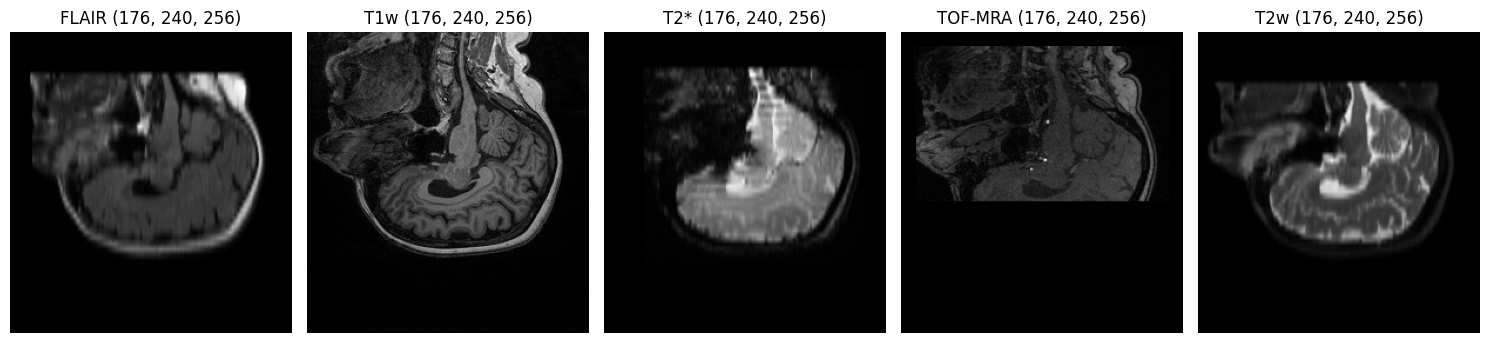

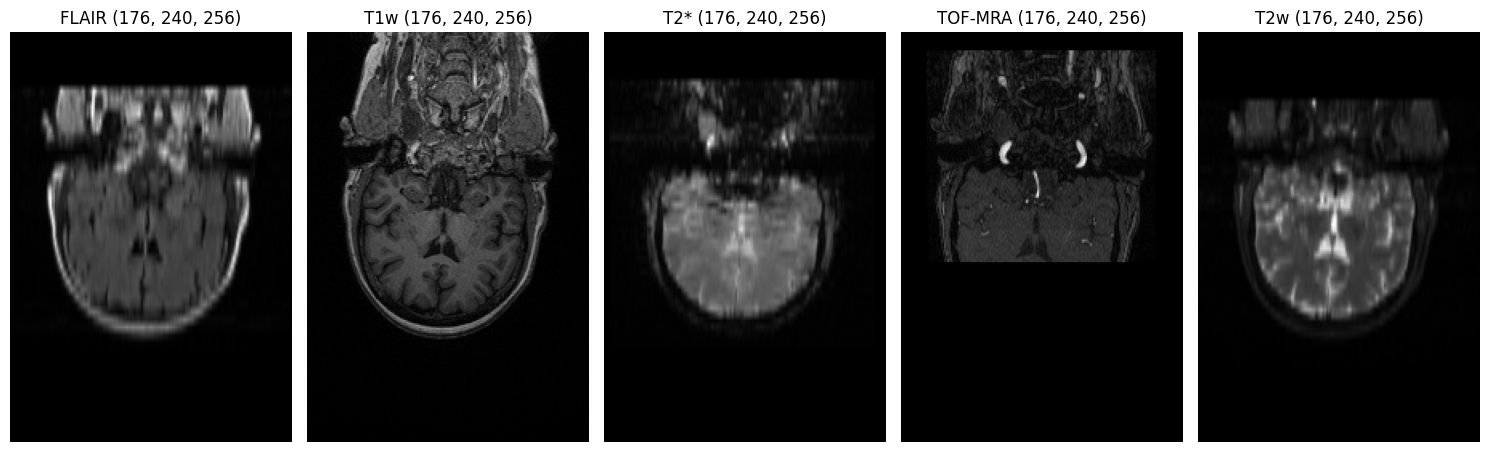

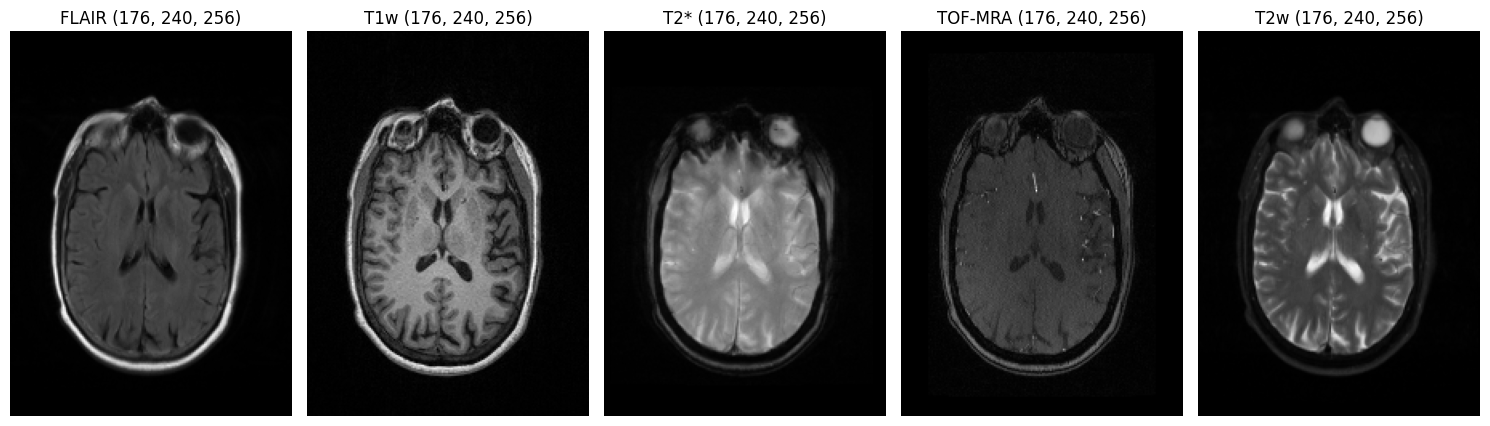

In [6]:
from oasis_util import visualize_structural_mri_session_data

visualize_structural_mri_session_data([flair_resampled, t1_ref_data, t2_star_resampled, mra_resampled, t2_resampled], ["FLAIR", "T1w", "T2*", "TOF-MRA", "T2w"], axis=0)
visualize_structural_mri_session_data([flair_resampled, t1_ref_data, t2_star_resampled, mra_resampled, t2_resampled], ["FLAIR", "T1w", "T2*", "TOF-MRA", "T2w"], axis=1)
visualize_structural_mri_session_data([flair_resampled, t1_ref_data, t2_star_resampled, mra_resampled, t2_resampled], ["FLAIR", "T1w", "T2*", "TOF-MRA", "T2w"], axis=2)

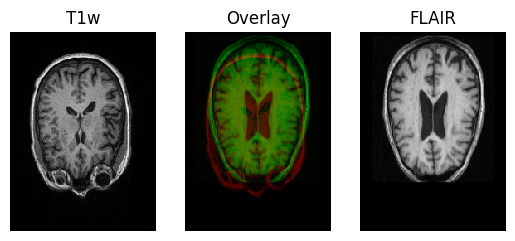

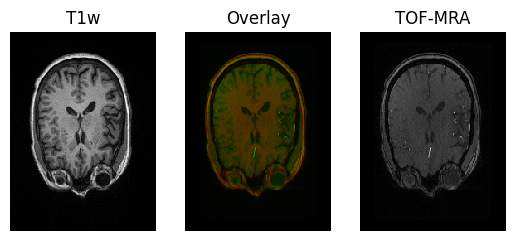

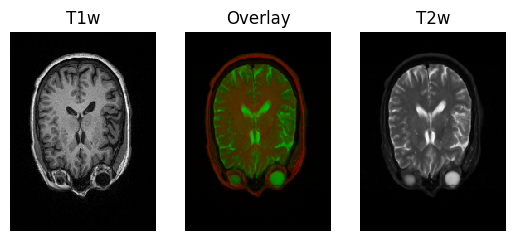

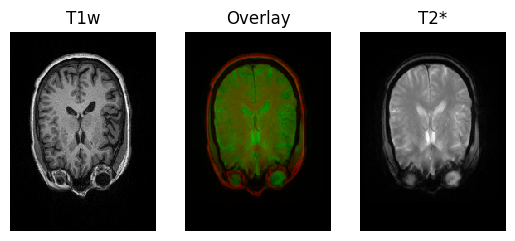

In [3]:
regtools.overlay_slices(t1_ref_data, flair_resampled, None, 2,
                         "T1w", "FLAIR", fname="unregistered", dpi=500)

regtools.overlay_slices(t1_ref_data, mra_resampled, None, 2,
                         "T1w", "TOF-MRA")

regtools.overlay_slices(t1_ref_data, t2_resampled, None, 2,
                         "T1w", "T2w")

regtools.overlay_slices(t1_ref_data, t2_star_resampled, None, 2,
                         "T1w", "T2*")

# almost perfectly registered using only metadata (affine + pixdim aka voxel shape) :D

# TODO: resample 16 full sessions and save to file

x = 0

In [9]:
nbins = 32
sampling_prop = None
metric = MutualInformationMetric(nbins, sampling_prop)

level_iters = [10, 10, 5]
sigmas = [3.0, 1.0, 0.0]
factors = [4, 2, 1]

affreg = AffineRegistration(metric=metric,
                             level_iters=level_iters,
                             sigmas=sigmas,
                             factors=factors)

transform = RigidTransform3D()
params0 = None
translation = affreg.optimize(t1_ref_data, flair_data, transform, params0,
                               t1_ref_affine, flair_affine)


Optimizing level 2 [max iter: 10]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 5]


[[ 1.     -0.0049 -0.0034 -0.0004]
 [ 0.0048  1.     -0.0076  0.0006]
 [ 0.0034  0.0076  1.     -0.0002]
 [ 0.      0.      0.      1.    ]]


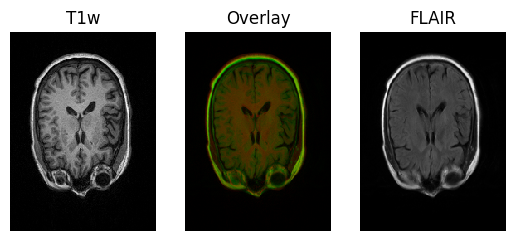

In [36]:
print(translation)

transformed = translation.transform(flair_data)
regtools.overlay_slices(t1_ref_data, transformed, None, 2,
                         "T1w", "FLAIR", fname="registered", dpi=500)
x=0

(240, 240, 155)
[[   1.    0.    0. -239.]
 [   0.    1.    0.    0.]
 [   0.    0.    1.    0.]
 [   0.    0.    0.    1.]]
[[  -1.2       0.        0.      105.    ]
 [   0.       -1.0547    0.      151.5625]
 [   0.        0.        1.0547 -133.9453]
 [   0.        0.        0.        1.    ]]


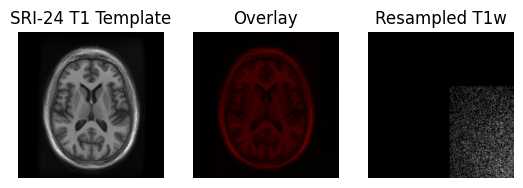

In [10]:
from dipy.viz import regtools
from dipy.align.imaffine import (AffineMap,
                                  MutualInformationMetric,
                                  AffineRegistration)

sri_24_t1_img = nib.load("../data/sri24/spgr_unstrip.nii")
t1_img = nib.load("../data/oasis-3-proc-1/OAS30001_MR_d2430/sub-OAS30001_ses-d2430_T1w_LPS.nii.gz")

sri_24_data = sri_24_t1_img.get_fdata()[:,:,:,0]
print(sri_24_data.shape)
sri_24_affine = sri_24_t1_img.affine
print(sri_24_affine)


t1_data = t1_img.get_fdata()
t1_affine = t1_img.affine
print(t1_affine)

identity = np.eye(4)
t1_affine_map = AffineMap(identity,
                        sri_24_data.shape, sri_24_affine,
                        t1_data.shape, t1_affine)
t1_sri_resampled = t1_affine_map.transform(t1_data)

regtools.overlay_slices(sri_24_data, t1_sri_resampled, None, 2,
                         "SRI-24 T1 Template", "Resampled T1w", fname="t1_sri_resampled", dpi=500)
x=0